<a href="https://colab.research.google.com/github/yugan243/Telco-Customer-Churn/blob/main/Data%20Preprocessing%20and%20Model%20Training/3_hyperparams_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yugan243/Telco-Customer-Churn.git


Cloning into 'Telco-Customer-Churn'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 156 (delta 61), reused 123 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (156/156), 2.89 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (61/61), done.


## HyperParameter Tuning with Cross Validation

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [2]:
%cd /content/Telco-Customer-Churn/'Data Preprocessing and Model Training'

/content/Telco-Customer-Churn/Data Preprocessing and Model Training


In [4]:
import sys

# Add the project's root directory to the system path
# This allows the notebook to find the 'Scripts' package
project_path = '/content/Telco-Customer-Churn'
if project_path not in sys.path:
    sys.path.append(project_path)

### Import Dependencies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from Scripts.business_focused_evaluator import BusinessModelEvaluator
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
                            classification_report,
                            confusion_matrix,
                            accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score,
                            )
warnings.filterwarnings('ignore')

### Data Loading

In [6]:
X_train = np.load('../Artifacts/X_train.npz', allow_pickle=True)['arr_0']
Y_train = np.load('../Artifacts/Y_train.npz', allow_pickle=True)['arr_0']
X_test = np.load('../Artifacts/X_test.npz', allow_pickle=True)['arr_0']
Y_test = np.load('../Artifacts/Y_test.npz', allow_pickle=True)['arr_0']

### 1. Random Forest + Grid Search CV + Stratified K Fold

In [17]:
# Define the parameter value ranges
params_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 15, 20],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt', 'log2']
            }

# Define the metrics want to track
scorings = {
        'f1': 'f1',
        'recall': 'recall',
        'precision': 'precision'
        }

# Setup the model and the CV
rf_clf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
                            estimator=rf_clf_tuned,
                            param_grid=params_grid,
                            scoring=scorings,
                            cv=cv_stratified,
                            verbose=2,
                            n_jobs=-1,
                            refit='f1',
                            )

# Run the hyperparemter search
print("Starting hyperparameter tuning for Random Forest...")
grid_search.fit(X_train, Y_train)
print("Tuning complete.")

# Print the best results
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best F1-Score (from CV): {grid_search.best_score_:.4f}")
print("Best hyperparameters:")
print(grid_search.best_params_)


# Get the index of the best model
best_index = grid_search.best_index_


# Print all metrics for the best model from the cross-validation results
print("\nCross-Validation Metrics for the Best Model:")
print(f"  - Mean F1-Score: {grid_search.cv_results_['mean_test_f1'][best_index]:.4f}")
print(f"  - Mean Recall:   {grid_search.cv_results_['mean_test_recall'][best_index]:.4f}")
print(f"  - Mean Precision:{grid_search.cv_results_['mean_test_precision'][best_index]:.4f}")

# Final Evaluation on the Test Set
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

print("\n--- Final Classification Report on Test Set ---")
print(classification_report(Y_test, y_pred_best_rf))

Starting hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Tuning complete.

--- Hyperparameter Tuning Results ---
Best F1-Score (from CV): 0.8519
Best hyperparameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

Cross-Validation Metrics for the Best Model:
  - Mean F1-Score: 0.8519
  - Mean Recall:   0.8683
  - Mean Precision:0.8364

--- Final Classification Report on Test Set ---
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1036
           1       0.60      0.63      0.61       373

    accuracy                           0.79      1409
   macro avg       0.73      0.74      0.74      1409
weighted avg       0.79      0.79      0.79      1409



### Evaluate with Business focussed metrics





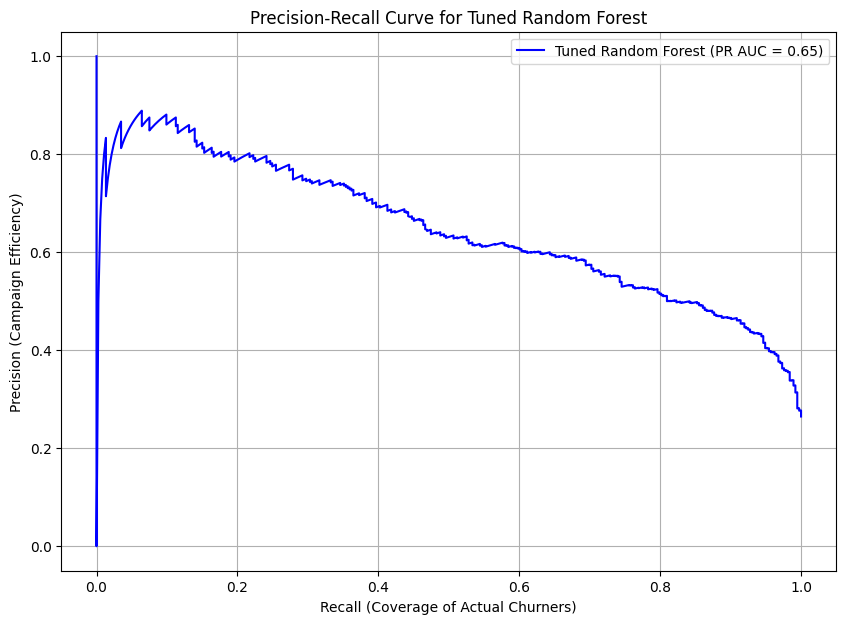

Precision-Recall AUC for Tuned Random Forest: 0.6460

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 157 -> Cost: $11,775.00
False Negatives (FN): 138 -> Cost: $276,000.00
Total Business Cost: $287,775.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.0783
Minimum Achievable Business Cost: $61,875.00

--- Cost-Sensitive Analysis at Threshold = 0.07831691638805084 ---
False Positives (FP): 665 -> Cost: $49,875.00
False Negatives (FN): 6 -> Cost: $12,000.00
Total Business Cost: $61,875.00


np.int64(61875)

In [18]:
best_rf_model = grid_search.best_estimator_

# Get Prediction Probabilities for Evaluation
y_probs_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]

# Define business costs
COST_FP = 75
COST_FN = 2000

# Create an instance of our evaluator
rf_tuned_evaluator = BusinessModelEvaluator(
                                            y_true=Y_test,
                                            y_pred_proba=y_probs_rf_tuned,
                                            model_name="Tuned Random Forest"
                                            )

# Run the Full Business-Focused Evaluation
rf_tuned_evaluator.plot_precision_recall_curve()
rf_tuned_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN)
optimal_thresh, min_cost = rf_tuned_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
rf_tuned_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh)

### 2. XGBoost + Grid Search CV + Stratified K Fold

In [8]:
# Define the Hyperparameter Grid for XGBoost
param_grid_xgb = {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.05, 0.1],
                'subsample': [0.7, 0.8],
                'colsample_bytree': [0.7, 0.8]
                }

scoring = {
          'f1': 'f1',
          'recall': 'recall',
          'precision': 'precision'
          }


xgb_clf_tuned = XGBClassifier(
                              use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42,
                              n_jobs=-1,
                              device='cuda'
                              )


# Initialize Stratified K-Fold cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# We will again use 'f1' as our primary metric to find a balanced model.
grid_search_xgb = GridSearchCV(
                              estimator=xgb_clf_tuned,
                              param_grid=param_grid_xgb,
                              cv=cv_stratified,
                              scoring=scoring,
                              refit='f1',
                              verbose=2,
                              n_jobs=-1
                              )

# Run the Hyperparameter Search
print("Starting hyperparameter tuning for XGBoost...")
grid_search_xgb.fit(X_train, Y_train)
print("Tuning complete.")

# Print the Comprehensive Best Results
print("\n--- Hyperparameter Tuning Results (XGBoost) ---")
print(f"Best F1-Score (from CV): {grid_search_xgb.best_score_:.4f}")
print("Best hyperparameters:")
print(grid_search_xgb.best_params_)

best_index_xgb = grid_search_xgb.best_index_
print("\nCross-Validation Metrics for the Best Model:")
print(f"  - Mean F1-Score: {grid_search_xgb.cv_results_['mean_test_f1'][best_index_xgb]:.4f}")
print(f"  - Mean Recall:   {grid_search_xgb.cv_results_['mean_test_recall'][best_index_xgb]:.4f}")
print(f"  - Mean Precision:{grid_search_xgb.cv_results_['mean_test_precision'][best_index_xgb]:.4f}")

# Final Evaluation on the Test Set
best_xgb_model = grid_search_xgb.best_estimator_

# Get standard classification report
y_pred_best_xgb = best_xgb_model.predict(X_test)
print("\n--- Final Classification Report on Test Set ---")
print(classification_report(Y_test, y_pred_best_xgb))


Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Tuning complete.

--- Hyperparameter Tuning Results (XGBoost) ---
Best F1-Score (from CV): 0.8544
Best hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

Cross-Validation Metrics for the Best Model:
  - Mean F1-Score: 0.8544
  - Mean Recall:   0.8526
  - Mean Precision:0.8564

--- Final Classification Report on Test Set ---
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1036
           1       0.63      0.65      0.64       373

    accuracy                           0.81      1409
   macro avg       0.75      0.76      0.75      1409
weighted avg       0.81      0.81      0.81      1409



### Evaluate with Business focussed metrics





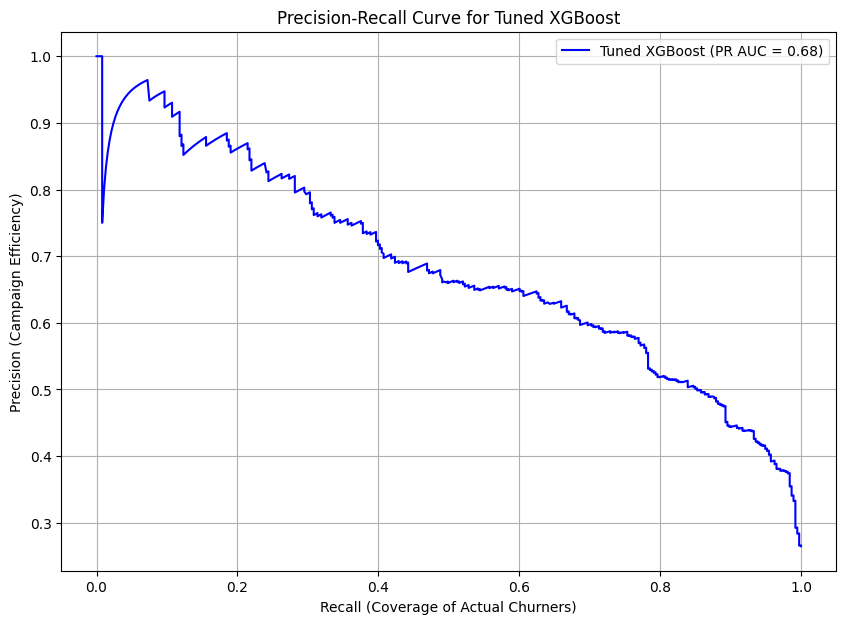

Precision-Recall AUC for Tuned XGBoost: 0.6823

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 142 -> Cost: $10,650.00
False Negatives (FN): 131 -> Cost: $262,000.00
Total Business Cost: $272,650.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.0684
Minimum Achievable Business Cost: $57,975.00

--- Cost-Sensitive Analysis at Threshold = 0.06844905018806458 ---
False Positives (FP): 613 -> Cost: $45,975.00
False Negatives (FN): 6 -> Cost: $12,000.00
Total Business Cost: $57,975.00


np.int64(57975)

In [10]:
best_xgb_model = grid_search_xgb.best_estimator_

# Get Prediction Probabilities for Evaluation
y_probs_xgb_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

# Define business costs
COST_FP = 75
COST_FN = 2000

# Create an instance of our evaluator
xgb_tuned_evaluator = BusinessModelEvaluator(
                                            y_true=Y_test,
                                            y_pred_proba=y_probs_xgb_tuned,
                                            model_name="Tuned XGBoost"
                                            )

# Run the Full Business-Focused Evaluation
xgb_tuned_evaluator.plot_precision_recall_curve()
xgb_tuned_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN)
optimal_thresh, min_cost = xgb_tuned_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
xgb_tuned_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh)

### 3. CatBoost + Grid Search CV + Stratified K Fold

In [11]:
# Define the Hyperparameter Grid for CatBoost
param_grid_cat = {
                'iterations': [200, 300],
                'learning_rate': [0.05, 0.1],
                'depth': [4, 6],
                'l2_leaf_reg': [1, 3, 5]
                }

# Set Up the Model and Cross-Validation
cat_clf_tuned = CatBoostClassifier(random_state=42, verbose=0 )
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
          'f1': 'f1',
          'recall': 'recall',
          'precision': 'precision'
          }

grid_search_cat = GridSearchCV(
                              estimator=cat_clf_tuned,
                              param_grid=param_grid_cat,
                              cv=cv_stratified,
                              scoring=scoring,
                              refit='f1',
                              verbose=2,
                              n_jobs=-1
                              )

# Run the Hyperparameter Search
print("Starting hyperparameter tuning for CatBoost...")
grid_search_cat.fit(X_train, Y_train)
print("Tuning complete.")

# Print the Comprehensive Best Results
print("\n--- Hyperparameter Tuning Results (CatBoost) ---")
print(f"Best F1-Score (from CV): {grid_search_cat.best_score_:.4f}")
print("Best hyperparameters:")
print(grid_search_cat.best_params_)

best_index_cat = grid_search_cat.best_index_
print("\nCross-Validation Metrics for the Best Model:")
print(f"  - Mean F1-Score: {grid_search_cat.cv_results_['mean_test_f1'][best_index_cat]:.4f}")
print(f"  - Mean Recall:   {grid_search_cat.cv_results_['mean_test_recall'][best_index_cat]:.4f}")
print(f"  - Mean Precision:{grid_search_cat.cv_results_['mean_test_precision'][best_index_cat]:.4f}")

# Final Evaluation on the Test Set
best_cat_model = grid_search_cat.best_estimator_

# Get standard classification report
y_pred_best_cat = best_cat_model.predict(X_test)
print("\n--- Final Classification Report on Test Set ---")
print(classification_report(Y_test, y_pred_best_cat))


Starting hyperparameter tuning for CatBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuning complete.

--- Hyperparameter Tuning Results (CatBoost) ---
Best F1-Score (from CV): 0.8539
Best hyperparameters:
{'depth': 4, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.05}

Cross-Validation Metrics for the Best Model:
  - Mean F1-Score: 0.8539
  - Mean Recall:   0.8511
  - Mean Precision:0.8570

--- Final Classification Report on Test Set ---
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1036
           1       0.64      0.67      0.65       373

    accuracy                           0.81      1409
   macro avg       0.76      0.77      0.76      1409
weighted avg       0.82      0.81      0.81      1409



### Evaluate with Business focussed metrics





In [ ]:
best_cat_model = grid_search_cat.best_estimator_

# Get Prediction Probabilities for Evaluation
y_probs_cat_tuned = best_cat_model.predict_proba(X_test)[:, 1]

# Define business costs
COST_FP = 75
COST_FN = 2000

# Create an instance of our evaluator
cat_tuned_evaluator = BusinessModelEvaluator(
                                            y_true=Y_test,
                                            y_pred_proba=y_probs_cat_tuned,
                                            model_name="Tuned CatBoost"
                                            )

# Run the Full Business-Focused Evaluation
cat_tuned_evaluator.plot_precision_recall_curve()
cat_tuned_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN)
optimal_thresh, min_cost = cat_tuned_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
cat_tuned_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh)